### Predictive Models

This notebook outlines the steps involved in building models incorporating **building, economic and socio-demographic factors**, including RF, SVR, ANN and OLS. The notebook then shows how to identify the significance of the characteristics.

In [1]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/transformed_df.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 50 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   LandUse                                                          8699 non-null   int64  
 1   LotArea                                                          8699 non-null   float64
 2   BldgArea                                                         8699 non-null   float64
 3   NumBldgs                                                         8699 non-null   int64  
 4   NumFloors                                                        8699 non-null   float64
 5   UnitsRes                                                         8699 non-null   int64  
 6   LotFront                                                         8699 non-null   float64
 7   LotDepth                                  

In [7]:
X = df[
    ['LandUse','LotArea', 'BldgArea', 'NumBldgs','NumFloors','ProxCode', 'UnitsRes', 'LotFront', 'LotDepth', 'BldgFront',
     'BldgDepth','LotType', 'AssessLand','BuiltFAR', 'BoroCode',
     'LargestPropertyUseTypeGrossFloorArea','Building_Age',
    'Mean_household_income_(dollars)','Civilian_noninstitutionalized_population_with_private_insurance', 
     'Population_with_determined_poverty_status','Population_with_65_years_and_over', 'Population',
     'Total_households', 'School_Employees', 'Population_with_bachelor_degree_or_higher', 'Married_males',
     'Married_females', 'Average_household_size', 'Vacant_housing_units', 'Median_Gross_Rent_(dollars)',
     'Housing_units_with_3_or_more_vehicles_available']
].values 
y = df['Weather_Normalized_Site_Energy_Use_(kBtu)'].values

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models
models = {
    'RF': RandomForestRegressor(),
    'SVR': SVR(),
    'ANN': MLPRegressor(),
    'OLS': LinearRegression()
}

# Store results
results = {model: {'R2': [], 'MAE': [], 'CVRMSE': [], 'RMSE': [], 'MAPE': []} for model in models.keys()}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        predictions = model.predict(X_val_fold)

        r2 = r2_score(y_val_fold, predictions)
        mae = mean_absolute_error(y_val_fold, predictions)
        rmse = mean_squared_error(y_val_fold, predictions, squared=False)
        cvrmse = rmse / np.mean(y_val_fold) * 100
        mape = np.mean(np.abs((y_val_fold - predictions) / y_val_fold)) * 100

        results[name]['R2'].append(r2)
        results[name]['MAE'].append(mae)
        results[name]['CVRMSE'].append(cvrmse)
        results[name]['RMSE'].append(rmse)
        results[name]['MAPE'].append(mape)

In [9]:
# Print the average performance metrics for each model
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for metric_name, metric_values in metrics.items():
        mean_value = np.mean(metric_values)
        print(f"  {metric_name}: {mean_value:.4f}")
    print()

Results for RF:
  R2: 0.7108
  MAE: 0.3227
  CVRMSE: 3.1946
  RMSE: 0.4976
  MAPE: 2.1233

Results for SVR:
  R2: 0.0709
  MAE: 0.6458
  CVRMSE: 5.7234
  RMSE: 0.8916
  MAPE: 4.1468

Results for ANN:
  R2: -5689.4666
  MAE: 52.3811
  CVRMSE: 436.3816
  RMSE: 67.9824
  MAPE: 337.3605

Results for OLS:
  R2: 0.6767
  MAE: 0.3476
  CVRMSE: 3.3775
  RMSE: 0.5261
  MAPE: 2.2868



#### Feature Importance Identification

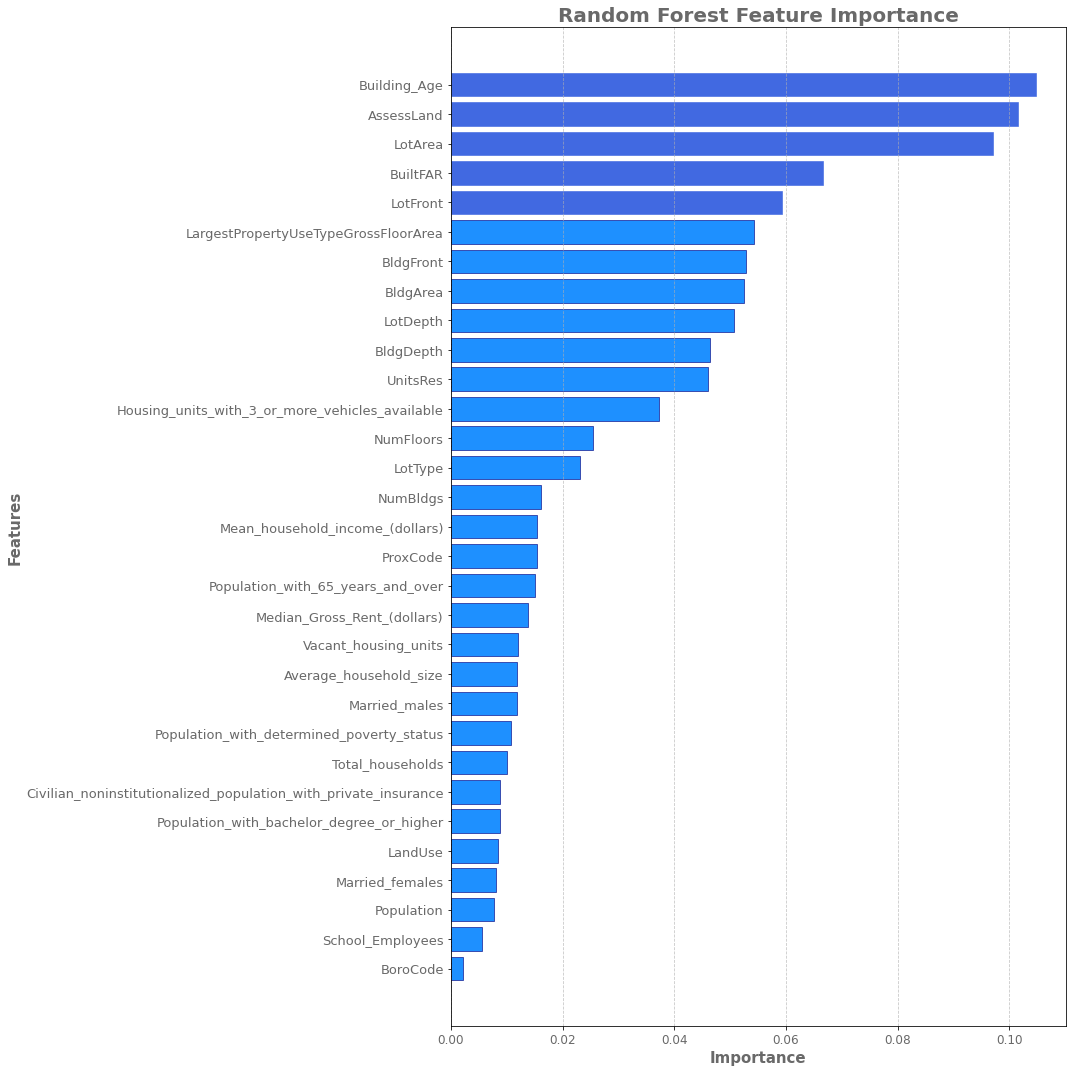

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names
feature_names = [
    'LandUse', 'LotArea', 'BldgArea', 'NumBldgs', 'NumFloors', 'ProxCode', 'UnitsRes', 'LotFront', 'LotDepth', 'BldgFront',
    'BldgDepth', 'LotType', 'AssessLand', 'BuiltFAR', 'BoroCode', 'LargestPropertyUseTypeGrossFloorArea', 'Building_Age',
    'Mean_household_income_(dollars)', 'Civilian_noninstitutionalized_population_with_private_insurance',
    'Population_with_determined_poverty_status', 'Population_with_65_years_and_over', 'Population', 'Total_households',
    'School_Employees', 'Population_with_bachelor_degree_or_higher', 'Married_males', 'Married_females', 'Average_household_size',
    'Vacant_housing_units', 'Median_Gross_Rent_(dollars)', 'Housing_units_with_3_or_more_vehicles_available'
]

# Extract the feature importances and sort them in descending order for plotting
importances = models['RF'].feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Creating the enhanced bar chart
plt.figure(figsize=(15, 15))
bars = plt.barh(np.array(feature_names)[sorted_indices], 
                importances[sorted_indices], 
                color='dodgerblue', 
                edgecolor='navy', 
                linewidth=0.6)

# Highlighting the top 5 features with a different color
top_features = 5
for i in range(top_features):
    bars[i].set_color('royalblue')

plt.xlabel('Importance', fontsize=15, fontweight='bold', color='dimgray')
plt.ylabel('Features', fontsize=15, fontweight='bold', color='dimgray')
plt.title('Random Forest Feature Importance', fontsize=20, fontweight='bold', color='dimgray')
plt.xticks(fontsize=12, color='dimgray')
plt.yticks(fontsize=13, color='dimgray')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()


In [14]:
# Fit the RF model on the entire training set
rf_model = models['RF']
rf_model.fit(X_train, y_train)

# Predict the values for the entire dataset
predicted_values = rf_model.predict(X)

# Add the predicted values to the dataframe
df['predicted_value'] = predicted_values

print(df[['Weather_Normalized_Site_Energy_Use_(kBtu)', 'predicted_value']].head())

   Weather_Normalized_Site_Energy_Use_(kBtu)  predicted_value
0                                  16.168388         0.566634
1                                  14.889625         0.540978
2                                  15.818122         0.590645
3                                  17.879746         0.590683
4                                  14.561637         0.565987


In [16]:
# Calculate the residuals
df['Residuals'] = df['Weather_Normalized_Site_Energy_Use_(kBtu)'] - df['predicted_value']

# Display the relevant columns
print(df[['Weather_Normalized_Site_Energy_Use_(kBtu)', 'predicted_value', 'Residuals']].head())


   Weather_Normalized_Site_Energy_Use_(kBtu)  predicted_value  Residuals
0                                  16.168388         0.566634  15.601754
1                                  14.889625         0.540978  14.348647
2                                  15.818122         0.590645  15.227477
3                                  17.879746         0.590683  17.289063
4                                  14.561637         0.565987  13.995651


In [18]:
# Save dataframe to a CSV file
df.to_csv('data/energy_mapping.csv', index=False)